In [1]:
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import os

CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

cube = h5py.File(CUBE_PATH, "r")

In [2]:
spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
wavelengths = cube["dense_cube/0/ml_spectrum/wl"][:]

metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

sfrs_notna = sfrs[sfrs["FLAG"] == 0.0]

ind_metadata = metadata[:, 0]["ds_slice_idx"]
idx_annotation = np.isin(ind_metadata, sfrs_notna.index.values)

X_spectra = spectra[idx_annotation]
Y = sfrs.loc[ind_metadata[idx_annotation]]["AVG"].values

In [3]:
THRESHOLD = 0.0
y_binary = (Y > THRESHOLD).astype(np.float32)

print(f"Размеры после фильтрации: X_spectra = {X_spectra.shape}, y_binary = {y_binary.shape}")

nan_rows = np.isnan(X_spectra).any(axis=1)
print(f"Количество строк с NaN: {nan_rows.sum()}")

X_spectra = X_spectra[~nan_rows]
y_binary = y_binary[~nan_rows]

print(f"Обновленные размеры: X_spectra = {X_spectra.shape}, y_binary = {y_binary.shape}")

Размеры после фильтрации: X_spectra = (16841, 4620), y_binary = (16841,)
Количество строк с NaN: 5662
Обновленные размеры: X_spectra = (11179, 4620), y_binary = (11179,)


In [4]:
X_tensor = torch.tensor(X_spectra, dtype=torch.float32)
y_tensor = torch.tensor(y_binary, dtype=torch.float32)

print(f"Размеры тензоров: X_tensor = {X_tensor.shape}, y_tensor = {y_tensor.shape}")

assert X_tensor.shape[0] == y_tensor.shape[0], "Размеры X_tensor и y_tensor должны совпадать"

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

Размеры тензоров: X_tensor = torch.Size([11179, 4620]), y_tensor = torch.Size([11179])


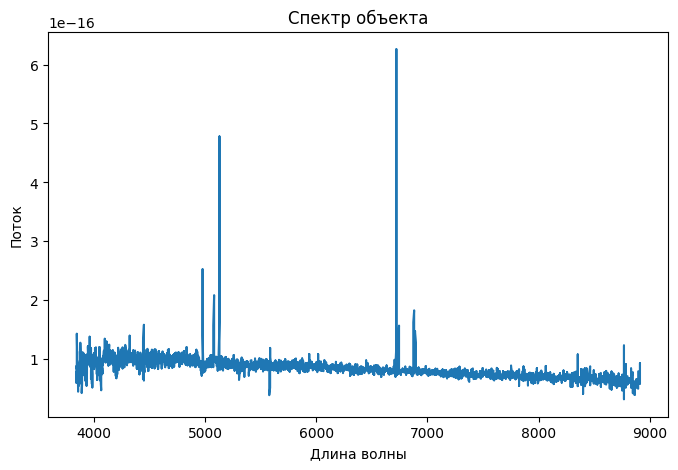

In [5]:
i = 45
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, X_spectra[i])
plt.title("Спектр объекта")
plt.xlabel("Длина волны")
plt.ylabel("Поток")
plt.show()

In [6]:
X_tensor = torch.tensor(X_spectra, dtype=torch.float32)
y_tensor = torch.tensor(y_binary, dtype=torch.float32)

print("Минимальное значение целевых данных:", y_tensor.min().item())
print("Максимальное значение целевых данных:", y_tensor.max().item())

Минимальное значение целевых данных: 0.0
Максимальное значение целевых данных: 1.0


In [7]:
mean = X_tensor.mean(dim=0)
std = X_tensor.std(dim=0)
std[std == 0] = 1  # Избегаем деления на 0
X_tensor = (X_tensor - mean) / std

In [8]:
nan_rows = np.isnan(X_spectra).any(axis=1) 
X_spectra = X_spectra[~nan_rows]
y_binary = y_binary[~nan_rows]

In [9]:
unique, counts = np.unique(y_binary, return_counts=True)
class_distribution = dict(zip(unique, counts))

print(f"Распределение классов: {class_distribution}")

Распределение классов: {0.0: 6462, 1.0: 4717}


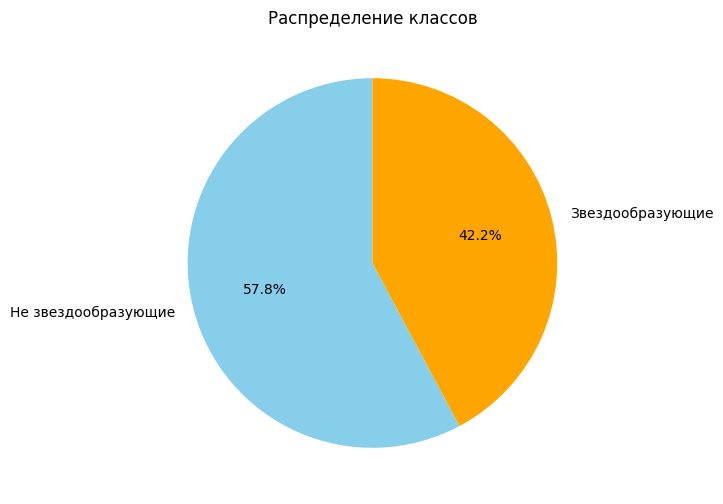

In [10]:
labels = ['Не звездообразующие', 'Звездообразующие']  # Подписи для классов
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title("Распределение классов")
plt.show()

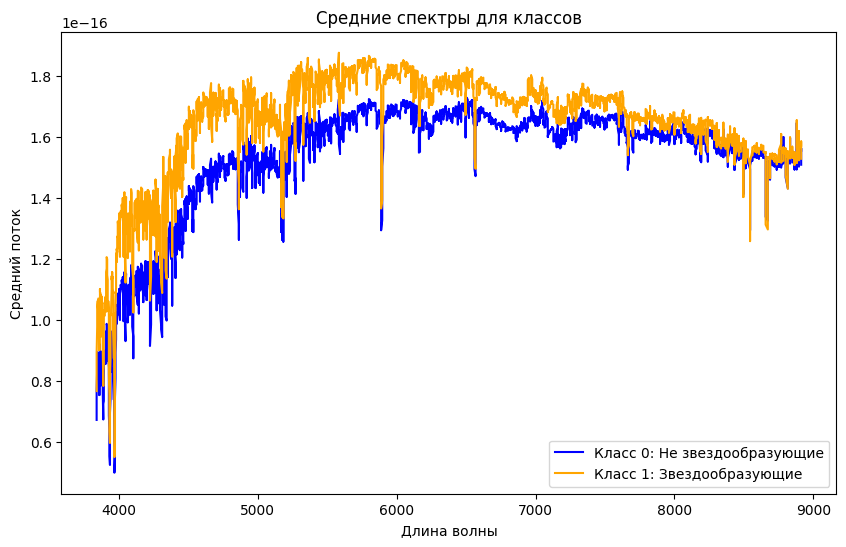

In [11]:
# Разделяем спектры по классам
spectra_class_0 = X_spectra[y_binary == 0]
spectra_class_1 = X_spectra[y_binary == 1]

# Средний спектр для каждого класса
mean_spectrum_0 = np.mean(spectra_class_0, axis=0)
mean_spectrum_1 = np.mean(spectra_class_1, axis=0)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, mean_spectrum_0, label="Класс 0: Не звездообразующие", color='blue')
plt.plot(wavelengths, mean_spectrum_1, label="Класс 1: Звездообразующие", color='orange')
plt.xlabel("Длина волны")
plt.ylabel("Средний поток")
plt.title("Средние спектры для классов")
plt.legend()
plt.show()


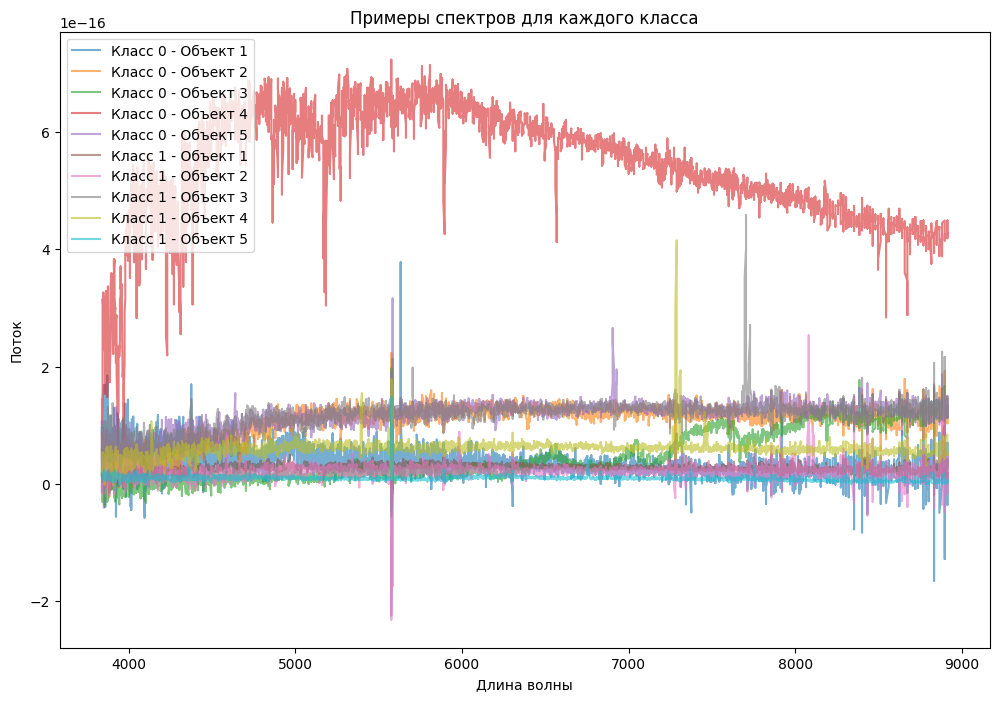

In [12]:
# Выбор случайных спектров для каждого класса
num_samples = 5  # Количество спектров для визуализации
indices_0 = np.random.choice(np.where(y_binary == 0)[0], num_samples, replace=False)
indices_1 = np.random.choice(np.where(y_binary == 1)[0], num_samples, replace=False)

plt.figure(figsize=(12, 8))

# Спектры класса 0
for i, idx in enumerate(indices_0):
    plt.plot(wavelengths, X_spectra[idx], label=f"Класс 0 - Объект {i+1}", alpha=0.6)

# Спектры класса 1
for i, idx in enumerate(indices_1):
    plt.plot(wavelengths, X_spectra[idx], label=f"Класс 1 - Объект {i+1}", alpha=0.6)

plt.xlabel("Длина волны")
plt.ylabel("Поток")
plt.title("Примеры спектров для каждого класса")
plt.legend()
plt.show()


In [13]:
print(sfrs.columns)

Index(['SIMPLE', 'BITPIX', 'NAXIS', 'EXTEND', 'TELESCOP', 'FLAVOR', 'BOSSVER',
       'MJD', 'MJDLIST', 'NAME',
       ...
       'RELEASE', 'AVG', 'ENTROPY', 'FLAG', 'MEDIAN', 'MODE', 'P16', 'P2P5',
       'P84', 'P97P5'],
      dtype='object', length=284)


In [14]:
X_tensor = torch.tensor(X_spectra, dtype=torch.float32)  
y_tensor = torch.tensor(y_binary, dtype=torch.float32)   

print(f"Размер X_tensor: {X_tensor.shape}")
print(f"Размер y_tensor: {y_tensor.shape}")

assert X_tensor.shape[0] == y_tensor.shape[0], "Размеры X_tensor и y_tensor должны совпадать"

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

Размер X_tensor: torch.Size([11179, 4620])
Размер y_tensor: torch.Size([11179])


In [15]:
class SpectraModel(nn.Module):
    def __init__(self, input_dim):
        super(SpectraModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Инициализация модели
input_dim = X_tensor.shape[1]
model = SpectraModel(input_dim=input_dim)

In [16]:
# Инициализация весов
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# Функция потерь и оптимизатор
criterion = nn.BCEWithLogitsLoss()  # Используем BCEWithLogitsLoss для численной стабильности
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Уменьшен learning rate

Эпоха 1, Средняя потеря: 0.6923, Точность: 0.5780
Эпоха 2, Средняя потеря: 0.6907, Точность: 0.5780
Эпоха 3, Средняя потеря: 0.6891, Точность: 0.5780
Эпоха 4, Средняя потеря: 0.6875, Точность: 0.5780
Эпоха 5, Средняя потеря: 0.6862, Точность: 0.5780
Эпоха 6, Средняя потеря: 0.6850, Точность: 0.5780
Эпоха 7, Средняя потеря: 0.6840, Точность: 0.5780
Эпоха 8, Средняя потеря: 0.6832, Точность: 0.5780
Эпоха 9, Средняя потеря: 0.6826, Точность: 0.5780
Эпоха 10, Средняя потеря: 0.6821, Точность: 0.5780
Эпоха 11, Средняя потеря: 0.6818, Точность: 0.5780
Эпоха 12, Средняя потеря: 0.6816, Точность: 0.5780
Эпоха 13, Средняя потеря: 0.6813, Точность: 0.5780
Эпоха 14, Средняя потеря: 0.6812, Точность: 0.5780
Эпоха 15, Средняя потеря: 0.6811, Точность: 0.5780
Эпоха 16, Средняя потеря: 0.6810, Точность: 0.5780
Эпоха 17, Средняя потеря: 0.6811, Точность: 0.5780
Эпоха 18, Средняя потеря: 0.6809, Точность: 0.5780
Эпоха 19, Средняя потеря: 0.6810, Точность: 0.5780
Эпоха 20, Средняя потеря: 0.6809, Точнос

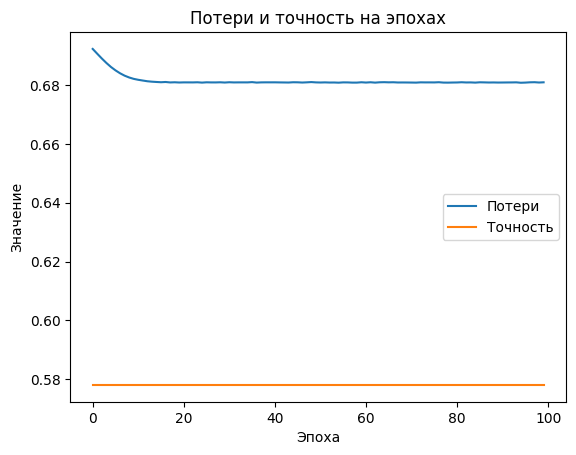

In [17]:
# Тренировочный цикл
num_epochs = 100
losses = []
accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        X_batch, y_batch = batch
        y_batch = y_batch.float()
        X_batch = X_batch.float()

        # Сбрасываем градиенты
        optimizer.zero_grad()

        # Предсказания модели
        y_pred = model(X_batch).squeeze()

        # Проверка на наличие nan в предсказаниях
        if torch.isnan(y_pred).any():
            print("Ошибка: nan в предсказаниях")
            continue

        # Вычисление потерь
        loss = criterion(y_pred, y_batch)

        # Проверка на наличие nan в потерях
        if torch.isnan(loss).any():
            print("Ошибка: nan в потерях")
            continue

        # Обратное распространение ошибки
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Преобразование логитов в вероятности
        y_prob = torch.sigmoid(y_pred)

        # Преобразование вероятностей в бинарные предсказания
        y_pred_binary = (y_prob > 0.5).float()

        # Сравнение предсказаний с истинными значениями
        correct_predictions += (y_pred_binary == y_batch).sum().item()
        total_predictions += y_batch.size(0)

    # Вычисление точности за эпоху
    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)

    # Логирование потерь и точности
    losses.append(epoch_loss / len(train_loader))
    print(f"Эпоха {epoch+1}, Средняя потеря: {epoch_loss / len(train_loader):.4f}, Точность: {accuracy:.4f}")

# Визуализация потерь
plt.plot(losses, label="Потери")
plt.plot(accuracies, label="Точность")
plt.title("Потери и точность на эпохах")
plt.xlabel("Эпоха")
plt.ylabel("Значение")
plt.legend()
plt.show()